Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'regressor__max_depth': 3, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Mean Squared Error: 3.07
R^2 Score: -0.07


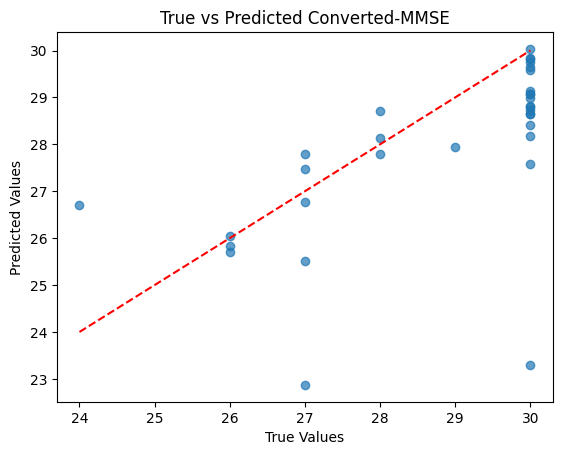

In [6]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


def load_data(file_pattern, base_path):
    data = []
    record_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids


def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df.set_index('Record-ID')[['Class', 'Age', 'Converted-MMSE']]


# Load and combine data for CTD, PFT, and SFT
base_path = "../process/PROCESS-V1/"
file_patterns = {
    'CTD': r"Process-rec-\d+__CTD\.txt",
    'PFT': r"Process-rec-\d+__PFT\.txt",
    'SFT': r"Process-rec-\d+__SFT\.txt"
}
data_dict = {}
record_ids_dict = {}

for key, pattern in file_patterns.items():
    data, record_ids = load_data(pattern, base_path)
    data_dict[key] = data
    record_ids_dict[key] = record_ids

# Load labels
label_file = "../process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels = load_labels(label_file)

combined_data = []
for record_id in labels.index:
    if all(record_id in record_ids_dict[key] for key in file_patterns):
        ctd_text = data_dict['CTD'][record_ids_dict['CTD'].index(record_id)]
        pft_text = data_dict['PFT'][record_ids_dict['PFT'].index(record_id)]
        sft_text = data_dict['SFT'][record_ids_dict['SFT'].index(record_id)]
        row = labels.loc[record_id]
        combined_data.append({
            'Record-ID': record_id,
            'CTD_Text': ctd_text,
            'PFT_Text': pft_text,
            'SFT_Text': sft_text,
            'Age': row['Age'],
            'Class': row['Class'],
            'Converted-MMSE': row['Converted-MMSE']
        })
# Create a DataFrame from combined data
df = pd.DataFrame(combined_data)

df['Class'] = df['Class'].astype('category').cat.codes  # Map Class to numeric codes

df.dropna(inplace=True)

# Combine all text for text feature extraction
df['Combined_Text'] = df['CTD_Text'] + ' ' + df['PFT_Text'] + ' ' + df['SFT_Text']


X = df[['Combined_Text', 'Age', 'Class']]
y = df['Converted-MMSE']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'Combined_Text'),  # Text features using TF-IDF
        ('numeric', MinMaxScaler(), ['Age', 'Class'])  # Scale numeric features
    ]
)

# Define regression model
model = GradientBoostingRegressor(random_state=42)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Define grid search parameters
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_samples_split': [2, 5, 10]
}

# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and best model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Converted-MMSE")
plt.show()
